# Data Exploration

### Data Loading

Root insurance data given in file "Root_Insurance_data.csv". 

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
main = pd.read_csv("Root_Insurance_data.csv")

In [3]:
main.sample(10)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
9864,N,3,2,S,10.0,5,False,0
4033,Y,3,1,S,10.0,3,False,0
8479,N,3,2,M,10.0,5,False,0
3148,unknown,3,1,S,10.0,3,False,0
3477,Y,1,2,S,10.0,3,False,0
9896,unknown,2,2,M,10.0,1,True,0
7424,N,3,2,S,10.0,4,False,0
8738,N,1,2,M,10.0,1,True,0
1374,Y,3,2,M,10.0,4,False,0
5310,Y,2,2,S,10.0,4,False,0


### Observations about Dependent Variables

All the observations have bid 10.0

In [5]:
main.bid.value_counts()

10.0    10000
Name: bid, dtype: int64

How about rank, click and policies_sold?

In [24]:
main["rank"].value_counts(normalize=1)

3    0.2401
5    0.2291
4    0.2089
1    0.1611
2    0.1608
Name: rank, dtype: float64

In [25]:
main["click"].value_counts(normalize=1)

False    0.8122
True     0.1878
Name: click, dtype: float64

In [26]:
main["policies_sold"].value_counts(normalize=1)

0    0.9217
1    0.0783
Name: policies_sold, dtype: float64

All policy purchases occur with a click.

In [27]:
main.loc[main["policies_sold"] == 1].loc[main["click"] == False].shape[0]

0

The number of clicks and purchases for customers from each ranking.

In [18]:
main.loc[main["click"]]["rank"].value_counts()

1    848
2    462
3    351
4    168
5     49
Name: rank, dtype: int64

In [19]:
main.loc[main["policies_sold"] == 1]["rank"].value_counts()

1    358
2    209
3    138
4     58
5     20
Name: rank, dtype: int64

Among the customers in each ranking, what is the proportion of (i) clicking?

In [44]:
click_prop = {}
for i in range(1,6):
    this = main.loc[main["rank"] == i].loc[main["click"]].shape[0]/main.loc[main["rank"] == i].shape[0]
    click_prop[i] = this
click_series = pd.Series(data = click_prop, index = range(1,6))
print(click_series)

1    0.526381
2    0.287313
3    0.146189
4    0.080421
5    0.021388
dtype: float64


(ii) purchase?

In [45]:
buy_prop = {}
for i in range(1,6):
    this = main.loc[main["rank"] == i].loc[main["policies_sold"] == 1].shape[0]/main.loc[main["rank"] == i].shape[0]
    buy_prop[i] = this
buy_series = pd.Series(data = buy_prop, index = range(1,6))
print(buy_series)

1    0.222222
2    0.129975
3    0.057476
4    0.027764
5    0.008730
dtype: float64


We see that, as expected, the proportions of both click and purchase decrease with the ranking.

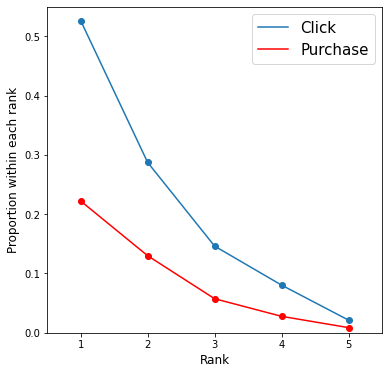

In [63]:
plt.figure(figsize=(6,6))
plt.scatter(range(1,6), click_series)
plt.scatter(range(1,6), buy_series, color = "r")
plt.plot(range(1,6), click_series, label = "Click")
plt.plot(range(1,6), buy_series, color = "r", label = "Purchase")
plt.xlim((0.5,5.5))
plt.ylim((0,0.55))
plt.xlabel("Rank", fontsize = 12)
plt.ylabel("Proportion within each rank", fontsize = 12)
plt.legend(fontsize = 15)
plt.show()

For each rank, given that the customer gives us a click, what is the proportion that they also make the purchase? (As we checked earlier, without a click, no one makes the purchase.)

In [46]:
cond_prop = {}
for i in range(1,6):
    cond_prop[i] = buy_prop[i]/click_prop[i]
cond_series = pd.Series(data = cond_prop, index = range(1,6))
print(cond_series)

1    0.422170
2    0.452381
3    0.393162
4    0.345238
5    0.408163
dtype: float64


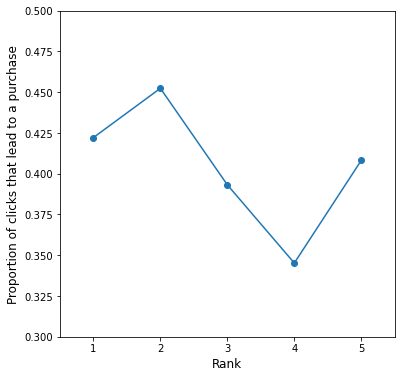

In [66]:
plt.figure(figsize=(6,6))
plt.scatter(range(1,6), cond_series)
plt.plot(range(1,6), cond_series)
plt.xlim((0.5,5.5))
plt.ylim((0.3,0.5))
plt.xlabel("Rank", fontsize = 12)
plt.ylabel("Proportion of clicks that lead to a purchase", fontsize = 12)
plt.show()

With the purchase as our goal, increasing a bid to move e.g. from rank 5 to rank 4 for a client may be less worthy than doing so to move from rank 4 to rank 3. Most importantly, it may not be that important to get up to rank 1, or to get away from rank 5, compared to the improvement between ranks 4, 3 and 2.

There may be some people who look at the first two or all five, and, being too lazy, just purchase the most recent option they have looked at.

#### What I learned so far?

Given the features (vehicles own, merital status, etc) of a client, our ultimate goal is to find (a) the lowest rank they need to be in order for them to make the purchase, and (b) the amount of bid required to put them in that rank.

One thing we cannot control is that every training data's bid is 10, making task (b) difficult. But since there is no way to improve this, we should focus on other parts of the problem.

First of all, among those whose rank is one but did not make a purchase, we should decrease their bid to zero. Identifying these customers based on their features and making their bid zero may be a good first step, or at least it should be incorporated into our general model. The same conclusion goes for rank-5 customers who purchase.

### Observations about Features

All the features: Currently Insured, Number of Vehicles, Number of Drivers and Marital Status, are categorical. Each of them also distributes quite evenly. In total, they make 35 categories of roughly the same size. One exception: no sampled data has {single, 2 drivers, 3 vehicles, unknown if currently insured}.

In [93]:
main["Currently Insured"].value_counts(normalize=1)

N          0.3444
Y          0.3419
unknown    0.3137
Name: Currently Insured, dtype: float64

In [94]:
main["Number of Vehicles"].value_counts(normalize=1)

2    0.3464
1    0.3441
3    0.3095
Name: Number of Vehicles, dtype: float64

In [95]:
main["Number of Drivers"].value_counts(normalize=1)

1    0.5001
2    0.4999
Name: Number of Drivers, dtype: float64

In [96]:
main["Marital Status"].value_counts(normalize=1)

M    0.5191
S    0.4809
Name: Marital Status, dtype: float64

In [193]:
main[["Currently Insured", "Number of Vehicles", "Number of Drivers", "Marital Status"]].value_counts(sort=False)

Currently Insured  Number of Vehicles  Number of Drivers  Marital Status
N                  1                   1                  M                 300
                                                          S                 271
                                       2                  M                 275
                                                          S                 283
                   2                   1                  M                 263
                                                          S                 272
                                       2                  M                 296
                                                          S                 316
                   3                   1                  M                 265
                                                          S                 286
                                       2                  M                 326
                                               

### Exploratory Analysis of Each Category

Next, we will try repeating the analysis in the first section with some example categories:

1) Insured, single customer with 1 vehicle and 1 driver.

In [168]:
cat4 = main.loc[main["Marital Status"] == "S"].loc[main["Number of Drivers"] == 1].loc[main["Number of Vehicles"] == 1].loc[main["Currently Insured"] == "Y"].copy()
cat4.sample(10)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
3520,Y,1,1,S,10.0,2,False,0
9624,Y,1,1,S,10.0,1,False,0
7030,Y,1,1,S,10.0,2,False,0
6316,Y,1,1,S,10.0,2,False,0
1551,Y,1,1,S,10.0,4,False,0
5043,Y,1,1,S,10.0,1,False,0
4987,Y,1,1,S,10.0,1,False,0
4733,Y,1,1,S,10.0,2,False,0
1679,Y,1,1,S,10.0,2,False,0
7364,Y,1,1,S,10.0,3,False,0


In [169]:
cat4.shape

(290, 8)

In [170]:
cat4["rank"].value_counts(normalize=1)

3    0.320690
2    0.255172
4    0.217241
1    0.206897
Name: rank, dtype: float64

In [171]:
cat4["click"].value_counts(normalize=1)

False    0.731034
True     0.268966
Name: click, dtype: float64

In [172]:
cat4["policies_sold"].value_counts(normalize=1)

0    0.868966
1    0.131034
Name: policies_sold, dtype: float64

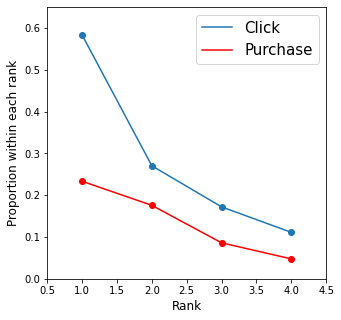

In [189]:
click_prop_cat4 = {}
buy_prop_cat4 = {}
cond_prop_cat4 = {}
for i in range(1,5):
    click_prop_cat4[i] = cat4.loc[cat4["rank"] == i].loc[cat4["click"]].shape[0]/cat4.loc[cat4["rank"] == i].shape[0]
    buy_prop_cat4[i] = cat4.loc[cat4["rank"] == i].loc[cat4["policies_sold"] == 1].shape[0]/cat4.loc[cat4["rank"] == i].shape[0]
    cond_prop_cat4[i] = buy_prop_cat4[i]/click_prop_cat4[i]
click_series_cat4 = pd.Series(data = click_prop_cat4, index = range(1,5))
buy_series_cat4 = pd.Series(data = buy_prop_cat4, index = range(1,5))
cond_series_cat4 = pd.Series(data = cond_prop_cat4, index = range(1,5))

plt.figure(figsize=(5,5))
plt.scatter(range(1,5), click_series_cat4)
plt.scatter(range(1,5), buy_series_cat4, color = "r")
plt.plot(range(1,5), click_series_cat4, label = "Click")
plt.plot(range(1,5), buy_series_cat4, color = "r", label = "Purchase")
plt.xlim((0.5,4.5))
plt.ylim((0,0.65))
plt.xlabel("Rank", fontsize = 12)
plt.ylabel("Proportion within each rank", fontsize = 12)
plt.legend(fontsize = 15)
plt.show()

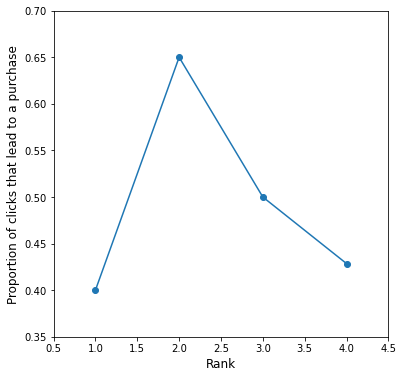

In [178]:
plt.figure(figsize=(6,6))
plt.scatter(range(1,5), cond_series_cat4)
plt.plot(range(1,5), cond_series_cat4)
plt.xlim((0.5,4.5))
plt.ylim((0.35,0.7))
plt.xlabel("Rank", fontsize = 12)
plt.ylabel("Proportion of clicks that lead to a purchase", fontsize = 12)
plt.show()

For this group of customers, we see that we got pretty good rankings even with the original bidding of 10 (Other insurance companies may not want to invest in these customers), and those among them who click on more than the first option have large tendency to buy the later options. This implies that we may not want to invest as much in this group of clients.

2) Uninsured, married customer with 3 vehicles and 2 drivers.

In [128]:
cat3 = main.loc[main["Marital Status"] == "M"].loc[main["Number of Drivers"] == 2].loc[main["Number of Vehicles"] == 3].loc[main["Currently Insured"] == "N"].copy()
cat3.sample(10)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
4043,N,3,2,M,10.0,5,True,1
2039,N,3,2,M,10.0,5,False,0
1687,N,3,2,M,10.0,5,False,0
3224,N,3,2,M,10.0,5,False,0
8639,N,3,2,M,10.0,5,False,0
7340,N,3,2,M,10.0,5,False,0
33,N,3,2,M,10.0,4,False,0
2186,N,3,2,M,10.0,4,True,1
9473,N,3,2,M,10.0,4,False,0
3243,N,3,2,M,10.0,5,False,0


In [129]:
cat3.shape

(326, 8)

In [161]:
cat3["rank"].value_counts(normalize=1)

5    0.463190
4    0.319018
3    0.217791
Name: rank, dtype: float64

In [162]:
cat3["click"].value_counts(normalize=1)

False    0.935583
True     0.064417
Name: click, dtype: float64

In [163]:
cat3["policies_sold"].value_counts(normalize=1)

0    0.966258
1    0.033742
Name: policies_sold, dtype: float64

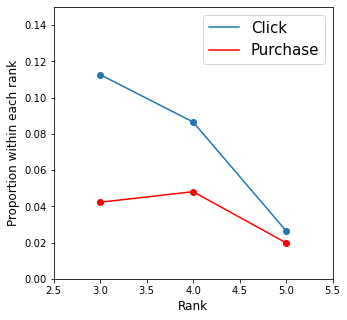

In [190]:
click_prop_cat3 = {}
buy_prop_cat3 = {}
for i in range(3,6):
    click_prop_cat3[i] = cat3.loc[cat3["rank"] == i].loc[cat3["click"]].shape[0]/cat3.loc[cat3["rank"] == i].shape[0]
    buy_prop_cat3[i] = cat3.loc[cat3["rank"] == i].loc[cat3["policies_sold"] == 1].shape[0]/cat3.loc[cat3["rank"] == i].shape[0]
click_series_cat3 = pd.Series(data = click_prop_cat3, index = range(3,6))
buy_series_cat3 = pd.Series(data = buy_prop_cat3, index = range(3,6))

plt.figure(figsize=(5,5))
plt.scatter(range(3,6), click_series_cat3)
plt.scatter(range(3,6), buy_series_cat3, color = "r")
plt.plot(range(3,6), click_series_cat3, label = "Click")
plt.plot(range(3,6), buy_series_cat3, color = "r", label = "Purchase")
plt.xlim((2.5,5.5))
plt.ylim((0,0.15))
plt.xlabel("Rank", fontsize = 12)
plt.ylabel("Proportion within each rank", fontsize = 12)
plt.legend(fontsize = 15)
plt.show()

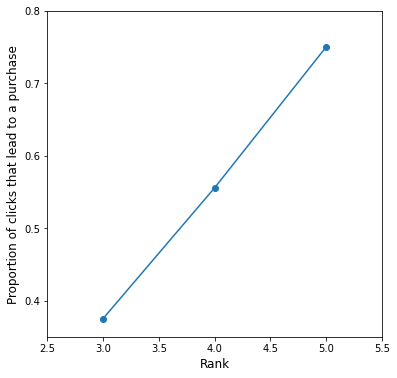

In [167]:
cond_prop_cat3 = {}
for i in range(3,6):
    cond_prop_cat3[i] = buy_prop_cat3[i]/click_prop_cat3[i]
cond_series_cat3 = pd.Series(data = cond_prop_cat3, index = range(3,6))

plt.figure(figsize=(6,6))
plt.scatter(range(3,6), cond_series_cat3)
plt.plot(range(3,6), cond_series_cat3)
plt.xlim((2.5,5.5))
plt.ylim((0.35,0.8))
plt.xlabel("Rank", fontsize = 12)
plt.ylabel("Proportion of clicks that lead to a purchase", fontsize = 12)
plt.show()

These clients are very attractive to other insurance companies; our original bidding of 10 never landed us in rank 1 or 2, and almost half of the bidding resulted in rank 5. An important observation, however, is that those in rank 4 are more likely to purchase than those in rank 3. Maybe it is not worth it to invest in this group either, if improving our ranking is too expensive.

3) Insured, married customer with 1 vehicle and 1 driver.

In [143]:
cat1 = main.loc[main["Marital Status"] == "M"].loc[main["Number of Drivers"] == 1].loc[main["Number of Vehicles"] == 1].loc[main["Currently Insured"] == "Y"].copy()
cat1.sample(10)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
6266,Y,1,1,M,10.0,4,False,0
689,Y,1,1,M,10.0,4,False,0
2428,Y,1,1,M,10.0,3,True,0
4382,Y,1,1,M,10.0,5,False,0
8940,Y,1,1,M,10.0,5,False,0
6036,Y,1,1,M,10.0,4,False,0
9999,Y,1,1,M,10.0,5,False,0
5355,Y,1,1,M,10.0,2,True,0
7219,Y,1,1,M,10.0,4,False,0
6746,Y,1,1,M,10.0,3,False,0


In [125]:
cat1.shape

(274, 8)

In [192]:
cat1["rank"].value_counts()

4    84
3    79
5    61
2    50
Name: rank, dtype: int64

In [135]:
cat1["click"].value_counts(normalize=1)

False    0.864964
True     0.135036
Name: click, dtype: float64

In [136]:
cat1["policies_sold"].value_counts(normalize=1)

0    0.959854
1    0.040146
Name: policies_sold, dtype: float64

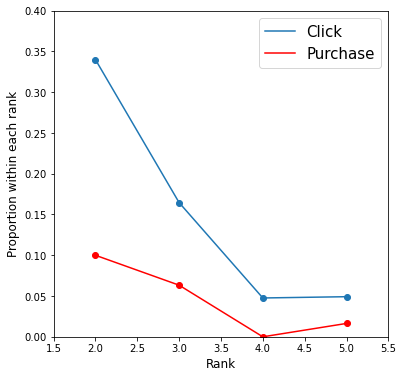

In [142]:
click_prop_cat1 = {}
buy_prop_cat1 = {}
for i in range(2,6):
    click_prop_cat1[i] = cat1.loc[cat1["rank"] == i].loc[cat1["click"]].shape[0]/cat1.loc[cat1["rank"] == i].shape[0]
    buy_prop_cat1[i] = cat1.loc[cat1["rank"] == i].loc[cat1["policies_sold"] == 1].shape[0]/cat1.loc[cat1["rank"] == i].shape[0]
click_series_cat1 = pd.Series(data = click_prop_cat1, index = range(2,6))
buy_series_cat1 = pd.Series(data = buy_prop_cat1, index = range(2,6))

plt.figure(figsize=(6,6))
plt.scatter(range(2,6), click_series_cat1)
plt.scatter(range(2,6), buy_series_cat1, color = "r")
plt.plot(range(2,6), click_series_cat1, label = "Click")
plt.plot(range(2,6), buy_series_cat1, color = "r", label = "Purchase")
plt.xlim((1.5,5.5))
plt.ylim((0,0.4))
plt.xlabel("Rank", fontsize = 12)
plt.ylabel("Proportion within each rank", fontsize = 12)
plt.legend(fontsize = 15)
plt.show()

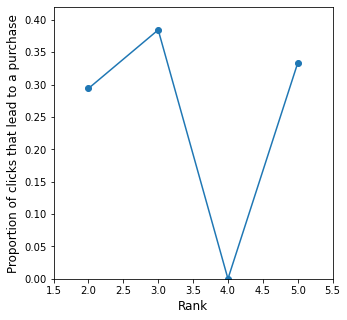

In [191]:
cond_prop_cat1 = {}
for i in range(2,6):
    cond_prop_cat1[i] = buy_prop_cat1[i]/click_prop_cat1[i]
cond_series_cat1 = pd.Series(data = cond_prop_cat1, index = range(2,6))

plt.figure(figsize=(5,5))
plt.scatter(range(2,6), cond_series_cat1)
plt.plot(range(2,6), cond_series_cat1)
plt.xlim((1.5,5.5))
plt.ylim((0,0.42))
plt.xlabel("Rank", fontsize = 12)
plt.ylabel("Proportion of clicks that lead to a purchase", fontsize = 12)
plt.show()

This group is not as difficult to achieve high rankings as the second group, but still much harder than the first. However, the fact that the purchase percentage is very low for rank 4-5 and increases 2-fold from 4 to 3 and 3 to 2 may imply that it is a good idea for us to bid more on this group.